In [1]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install rfpimp
!{sys.executable} -m pip install yellowbrick
!{sys.executable} -m pip install eli5
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!{sys.executable} -m jupyter nbextension enable --py widgetsnbextension

Requirement already up-to-date: pandas-profiling[notebook] in d:\anaconda\lib\site-packages (2.11.0)


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from rfpimp import plot_importances
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import GridSearchCV

from eli5.sklearn import PermutationImportance
from matplotlib import pyplot


%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Define all the csv input data files
people = pd.read_csv("PEOPLE.csv")
subj_pref = pd.read_csv("C_SUBJECT_PREF.csv")
region_pref = pd.read_csv("C_REGION_PREF.csv")
regions = pd.read_csv("REGIONS_DESC.csv")

In [4]:
# Merge all the data into 1 data frame (for easier operations)
all_data = pd.merge(people, subj_pref, how='outer', on="PERSONID")
region_data = pd.merge(region_pref, regions, how='outer', on="REGION_CODE")
all_data = pd.merge(all_data, region_data, how='outer', on="PERSONID")

len(all_data.PERSONID.unique())

9913

In [5]:
all_data.head(5)

,PERSONID,Applicant_Pool,UNIV_Selectivity,UNIV_Major,Candidate_Strength,Low_IncomeComm_Ex,Low_IncomeComm_Ex_L,Mission_KNWL_ALNMT,FastApp,ESSAY_Length,ESSAY_T1,ESSAY_T2,ESSAY_T3,ESSAY_T4,ESSAY_T5,ESSAY_T6,ESSAY_T7,ESSAY_T8,ESSAY_T9,ESSAY_T10,MATCH_REGION_CODE,MATCH_Subject,MATCH_is_home_region,MATCH_is_UNIV_Region,MATCH_is_Current_Region,MATCH_District,MATCH_School,MATCH_School_Type,MATCH_Grade_Level,MATCH_Y1_subject_group,OUTCOME_1_Confirmed,OUTCOME_2_StartTeaching,OUTCOME_3_Complet_Y1,OC_Satisfaction_Y1,OUTCOME_4_Complet_Y2,OC_Satisfaction_Y2,MATCH_Region_Pref_Level,MATCH_Region_Pref_Rank,MATCH_Subject_Prefer,SUBJECT_Pref,SUBJECT_Pref_Level,SUBJECT_Teach_Mapping,REGION_CODE,REGION_Pref_Level,REGION_Pref_Rank,CERT_COST,RENT_2_shared,RENT_1_single,Y1_MIN_SAL,Y1_MAX_SAL,Y2_MIN_SAL,Y2_MAX_SAL,SEX_RATIO_ M,AGE_20_24,AGE_25_29,AGE_30_34,AGE_35_39,AGE_40_44,AGE_45_49,RACE_NON_WHITE,RACE_Two_or_more,Population_size,ED_ATN_Less_9G,ED_ATN_HS_p,ED_ATN_Bachelor_p,TEMP_MAX_JAN,TEMP_MAX_FEB,TEMP_MAX_MAR,TEMP_MAX_APR,TEMP_MAX_MAY,TEMP_MAX_JUN,TEMP_MAX_JUL,TEMP_MAX_AUG,TEMP_MAX_SEP,TEMP_MAX_OCT,TEMP_MAX_NOV,TEMP_MAX_DEC,TEMP_MAX_ANN,TEMP_MIN_JAN,TEMP_MIN_FEB,TEMP_MIN_MAR,TEMP_MIN_APR,TEMP_MIN_MAY,TEMP_MIN_JUN,TEMP_MIN_JUL,TEMP_MIN_AUG,TEMP_MIN_SEP,TEMP_MIN_OCT,TEMP_MIN_NOV,TEMP_MIN_DEC,TEMP_MIN_ANN,SUN_PERCT_JAN,SUN_PERCT_FEB,SUN_PERCT_MAR,SUN_PERCT_APR,SUN_PERCT_MAY,SUN_PERCT_JUN,SUN_PERCT_JUL,SUN_PERCT_AUG,SUN_PERCT_SEP,SUN_PERCT_OCT,SUN_PERCT_NOV,SUN_PERCT_DEC,SUN_PERCT_ANN,DEM_perc_16,DEM_perc_20,GOP_perc_16,GOP_perc_20,delta_turnout,ECON_GINI,TOURISTS,WALKSCORE,BIKESCORE,TRANISTCORE
0,100064,A,More Selective,Art,0.755037,Y,LEVEL3,4.0,0,1697,0.002566,0.002565,0.487455,0.002565,0.073422,0.002567,0.002566,0.002565,0.421163,0.002565,401,HSGENSCIENCE,True,True,True,Partner 379,School 2398,Traditional Public School,HIGH,Science,1,1,1,7.0,1,6.75,1.0,1.0,2,NaN,NaN,NaN,411.0,2.0,1.0,0.0,700.0,1150.0,36000.0,48000.0,36000.0,48000.0,92.7,5.7,6.9,7.3,7.1,6.4,5.9,0.4265,0.0195,small,3.6,91.2,38.2,62.1,65.4,71.8,78.2,85.2,89.5,91.2,91.2,87.5,80.0,71.8,64.4,78.2,44.7,48.0,53.5,60.0,68.1,73.5,75.3,75.3,72.0,62.6,53.5,46.9,61.2,48.0,52.0,56.0,62.0,59.0,67.0,61.0,59.0,61.0,70.0,57.0,54.0,58.0,0.509,0.539,0.449,0.443,1.101,0.4942,0.007167,59.0,66.0,44.0
1,100064,A,More Selective,Art,0.755037,Y,LEVEL3,4.0,0,1697,0.002566,0.002565,0.487455,0.002565,0.073422,0.002567,0.002566,0.002565,0.421163,0.002565,401,HSGENSCIENCE,True,True,True,Partner 379,School 2398,Traditional Public School,HIGH,Science,1,1,1,7.0,1,6.75,1.0,1.0,2,NaN,NaN,NaN,419.0,3.0,5.0,0.0,100.0,1600.0,47500.0,52500.0,47500.0,52500.0,94.5,5.7,6.6,6.7,6.3,6.7,6.9,0.2999,0.0263,big city,7.1,90.8,34.4,76.4,78.1,80.3,83.2,87.0,89.5,90.9,91.0,89.3,86.2,81.7,77.9,84.3,59.9,62.3,64.9,68.3,72.9,76.0,77.3,77.4,76.5,73.5,68.1,63.0,70.1,68.0,68.0,74.0,79.0,73.0,70.0,77.0,72.0,69.0,72.0,63.0,66.0,70.0,0.637,0.534,0.341,0.461,1.203,0.5076,0.004167,78.0,65.0,57.0
2,100064,A,More Selective,Art,0.755037,Y,LEVEL3,4.0,0,1697,0.002566,0.002565,0.487455,0.002565,0.073422,0.002567,0.002566,0.002565,0.421163,0.002565,401,HSGENSCIENCE,True,True,True,Partner 379,School 2398,Traditional Public School,HIGH,Science,1,1,1,7.0,1,6.75,1.0,1.0,2,NaN,NaN,NaN,432.0,3.0,3.0,2608.0,900.0,1725.0,37218.0,49100.0,37218.0,49100.0,97.7,4.5,5.8,6.3,7.9,6.3,6.2,0.6638,0.2113,very small,4.7,95.2,24.2,80.1,80.2,81.2,82.7,84.6,87.0,87.9,88.7,88.6,86.7,83.9,81.2,84.4,66.3,66.1,67.7,69.4,70.9,73.4,74.5,75.1,74.4,73.4,71.4,68.3,70.9,59.0,62.0,68.0,63.0,66.0,67.0,71.0,73.0,75.0,67.0,60.0,56.0,65.0,0.615,0.625,0.316,0.357,1.411,0.4333,0.000300,23.0,23.0,36.0
3,100064,A,More Selective,Art,0.755037,Y,LEVEL3,4.0,0,1697,0.002566,0.002565,0.487455,0.002565,0.073422,0.002567,0.002566,0.002565,0.421163,0.002565,401,HSGENSCIENCE,True,True,True,Partner 379,School 2398,Traditional Public School,HIGH,Science,1,1,1,7.0,1,6.75,1.0,1.0,2,NaN,NaN,NaN,400.0,1.0,2.0,2300.0,720.0,1200.0,44000.0,47000.0,44000.0,47000.0,93.5,6.4,7.3,7.0,7.1,6.8,7.2,0.4778,0.0276,bi

In [6]:
# Data cleaning
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'More selective', 'More Selective',  all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'Least Selective', 1, all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'Less Selective', 2, all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'Selective', 3, all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'More Selective', 4, all_data.UNIV_Selectivity)
all_data.UNIV_Selectivity = np.where(all_data.UNIV_Selectivity == 'Most Selective', 5, all_data.UNIV_Selectivity)

all_data.UNIV_Selectivity = all_data.UNIV_Selectivity.astype(int)
all_data.MATCH_is_home_region = all_data.MATCH_is_home_region.astype(int)
all_data.MATCH_is_UNIV_Region = all_data.MATCH_is_UNIV_Region.astype(int)
all_data.MATCH_is_Current_Region = all_data.MATCH_is_Current_Region.astype(int)

all_data.Low_IncomeComm_Ex = np.where(all_data.Low_IncomeComm_Ex == 'Y', 1,  all_data.Low_IncomeComm_Ex)
all_data.Low_IncomeComm_Ex = np.where(all_data.Low_IncomeComm_Ex == 'N', 0,  all_data.Low_IncomeComm_Ex)
all_data.Low_IncomeComm_Ex.fillna(all_data.Low_IncomeComm_Ex.mean(), inplace=True)

all_data.Low_IncomeComm_Ex_L = np.where(all_data.Low_IncomeComm_Ex_L == 'LEVEL1', 1,  all_data.Low_IncomeComm_Ex_L)
all_data.Low_IncomeComm_Ex_L = np.where(all_data.Low_IncomeComm_Ex_L == 'LEVEL2', 2,  all_data.Low_IncomeComm_Ex_L)
all_data.Low_IncomeComm_Ex_L = np.where(all_data.Low_IncomeComm_Ex_L == 'LEVEL3', 3,  all_data.Low_IncomeComm_Ex_L)
all_data.Low_IncomeComm_Ex_L.fillna(all_data.Low_IncomeComm_Ex_L.mean(), inplace=True)

all_data.Candidate_Strength.fillna(all_data.Candidate_Strength.mean(), inplace=True)
all_data.Mission_KNWL_ALNMT.fillna(all_data.Mission_KNWL_ALNMT.mean(), inplace=True)

all_data.MATCH_Region_Pref_Level.fillna(all_data.MATCH_Region_Pref_Level.mean(), inplace=True)
all_data.MATCH_Region_Pref_Rank.fillna(all_data.MATCH_Region_Pref_Rank.mean(), inplace=True)

all_data.REGION_Pref_Level.fillna(all_data.REGION_Pref_Level.mean(), inplace=True)
all_data.REGION_Pref_Rank.fillna(all_data.REGION_Pref_Rank.mean(), inplace=True)

all_data.ED_ATN_Bachelor_p.fillna(all_data.ED_ATN_Bachelor_p.mean(), inplace=True)

In [7]:
# Adding my own columns
all_data['is_subject_matched'] = np.where(all_data.SUBJECT_Pref == all_data.MATCH_Subject, 1 ,0)
all_data['is_positive_exp'] = np.where((all_data.OC_Satisfaction_Y2 >= 4.0) & (all_data.OC_Satisfaction_Y1 >= 4.0) & (all_data.OUTCOME_4_Complet_Y2 == 1), 1 ,0)

all_data['home_eol'] = (all_data.WALKSCORE + all_data.BIKESCORE + all_data.TRANISTCORE) / 300
all_data['home_eol'].fillna(all_data.home_eol.mean(), inplace=True)

all_data['is_region_match'] = np.where((all_data.MATCH_is_home_region == 1) & (all_data.MATCH_is_UNIV_Region == 1) & (all_data.MATCH_is_Current_Region == 1), 1 ,0)

all_data['region_match_level'] = np.where(all_data.MATCH_is_home_region == 1, 1, 0)
all_data['region_match_level'] = np.where(all_data.MATCH_is_UNIV_Region == 1, all_data.region_match_level+1, 0)
all_data['region_match_level'] = np.where(all_data.MATCH_is_Current_Region == 1, all_data.region_match_level+1, 0)

all_data['is_perfect_candidate'] = np.where((all_data.Candidate_Strength > 0.8) & (all_data.ED_ATN_Bachelor_p > 0.6), 1, 0)

<AxesSubplot:>

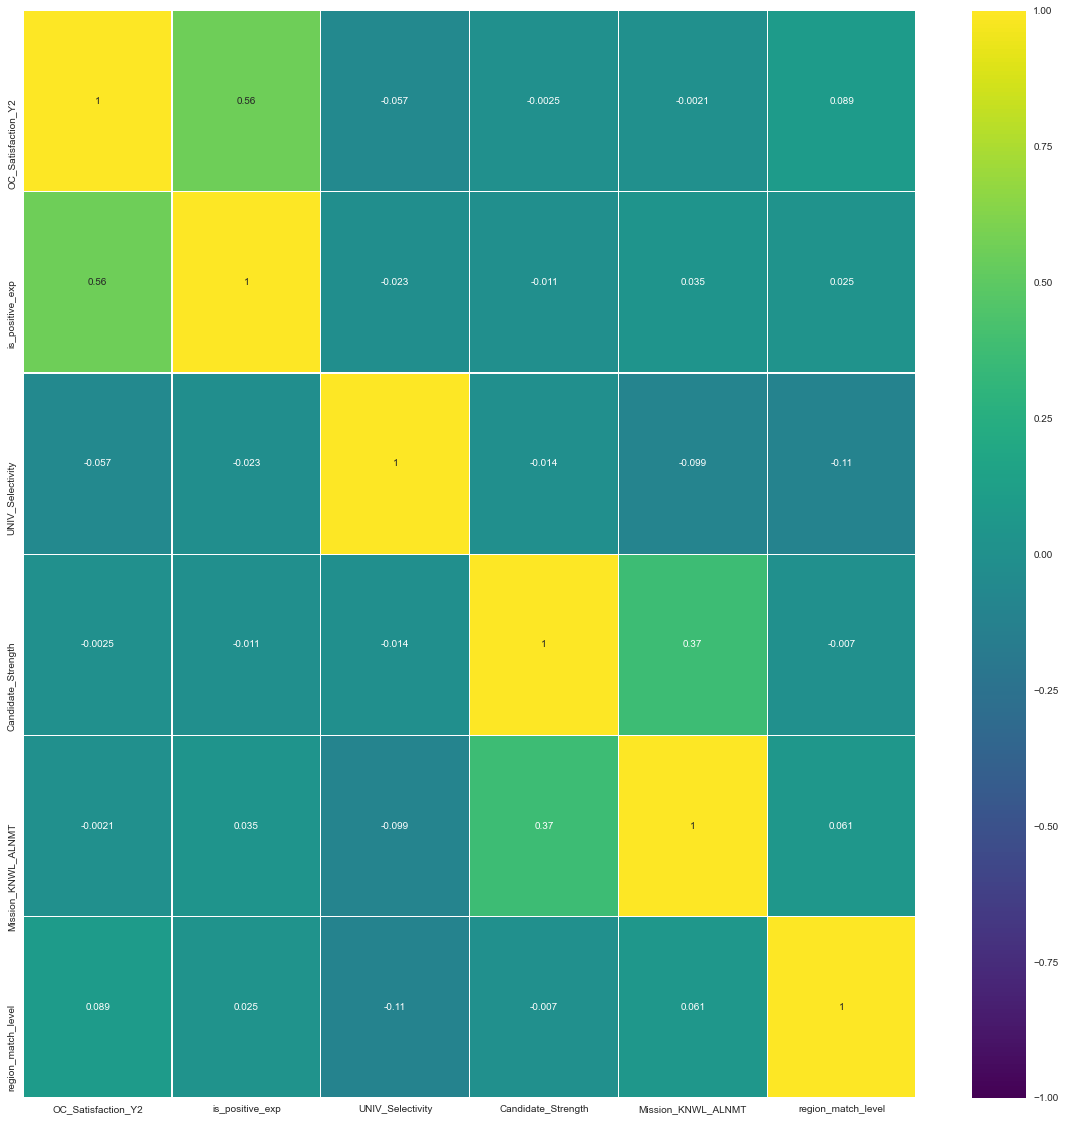

In [8]:
# Print correlation table
plt.figure(figsize=(20,20))
considered_cols = [
#     'OUTCOME_4_Complet_Y2',
    'OC_Satisfaction_Y2',
    'is_positive_exp',
    'UNIV_Selectivity',
    'Candidate_Strength',
#     'Low_IncomeComm_Ex_L',
    'Mission_KNWL_ALNMT',
#     'FastApp',
#     'ED_ATN_Bachelor_p',
#     'is_perfect_candidate',
#     'is_subject_matched',
#     'is_region_match',
    'region_match_level',
#     'home_eol'
]

correlation = all_data[considered_cols].corr()
sns.heatmap(correlation, vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=0.1)

In [9]:
# Keep backup of all_data
all_data_backup = all_data

In [10]:
# Prepare data for model fitting
all_data = all_data_backup
wanted_outcome = 'OC_Satisfaction_Y2'

# We will just drop NAs
all_data = all_data.dropna(subset=[wanted_outcome])

labels = all_data[wanted_outcome]
features = all_data[considered_cols[2:len(considered_cols)]]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.50)

print("Train features:", len(x_train))
print("Test features:", len(x_test))

print("Train labels:", len(y_train))
print("Test labels:", len(y_test))

Train features: 45377
Test features: 45377
Train labels: 45377
Test labels: 45377


In [11]:
print ("Features na:\n", features.isna().sum())
print ("Labels na:", labels.isna().sum())

Features na:
 UNIV_Selectivity      0
Candidate_Strength    0
Mission_KNWL_ALNMT    0
region_match_level    0
dtype: int64
Labels na: 0


In [12]:
plot_importances()

TypeError: plot_importances() missing 1 required positional argument: 'df_importances'

In [ ]:
# Main function to run the model and predictions on test / training sets
def fit_model(train_features, test_features, train_labels, test_labels):
    
    test_params = {
        "n_estimators": [95, 105, 115],
#         "n_estimators": [105],
        "max_depth": [10, 12, 14]
#         "max_depth": [10]
    }
    
    rf = RandomForestRegressor(n_jobs = -1,
                               oob_score = True,
                               bootstrap = True,
                               random_state = 42)
    
    grid = GridSearchCV(rf, test_params, n_jobs=-1)
    grid.fit(features, labels)
    
    print("Best score:", grid.best_score_)
    print("Best params:", grid.best_params_)
    
    rf = RandomForestRegressor(n_jobs = -1,
                               n_estimators = grid.best_params_['n_estimators'],
                               max_depth = grid.best_params_['max_depth'],
                               oob_score = True,
                               bootstrap = True,
                               random_state = 42)
    
    rf.fit(features, labels)
    prediction_labels = rf.predict(test_features)
    print ("Predicition labels (outcomes) length:", len(prediction_labels))
    
     # if the training score R^2, and the validation score R^2 are far apart, then we are most likely overfitting
    print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'
          .format(rf.score(train_features, train_labels), rf.oob_score_, rf.score(test_features, test_labels)))
    
    # First way of calculating importances, default sklearn way
    importances = pd.DataFrame({'col_name': rf.feature_importances_}, index=features.columns).sort_values(by='col_name', ascending=False)

    # Second way of checking importances (rfpimp)
    perm_imp_rfpimp = permutation_importances(rf, train_features, train_labels, r2)
    plot_importances(perm_imp_rfpimp)
    
    # Make a bar chart
    plt.style.use('fivethirtyeight')
    
    plt.figure(3)
    plt.bar(importances.index, importances.col_name, orientation = 'vertical')
    plt.xticks(importances.index, importances.index, rotation = 'vertical')
    plt.ylabel('Importance sklearn')
    
    
    # Third way of checking importants (eli5)
    perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(train_features, train_labels)
    perm_imp_eli5 = imp_df(train_features.columns, perm.feature_importances_)

    plt.figure(2)
    plt.bar(perm_imp_eli5.feature, perm_imp_eli5.feature_importance, orientation = 'vertical')
    plt.xticks(perm_imp_eli5.feature, perm_imp_eli5.feature, rotation = 'vertical')
    plt.ylabel('Importance')

    return prediction_labels
    
# Importance of variables for the model ( 2nd way of doing r2)
def r2(rf, train_features, train_labels):
    return r2_score(train_labels, rf.predict(train_features))

def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

In [ ]:
prediction_results = fit_model(x_train, x_test, y_train, y_test)

In [ ]:
# Let's assume we have a good model ...
results = pd.concat([x_test, pd.DataFrame(y_test)], axis=1)
results['prediction_Y2_Satisfaction'] = prediction_results
results[['Candidate_Strength', 'region_match_level', 'UNIV_Selectivity', 'Mission_KNWL_ALNMT', 'OC_Satisfaction_Y2', 'prediction_Y2_Satisfaction']].head(50)

In [ ]:
# We can graph the distributions of both prediction / actual values here (and we can do an After, once we split into 1/0 values)
results.OC_Satisfaction_Y2.plot(kind='hist', alpha=.5, legend=True)
results.prediction_Y2_Satisfaction.plot(kind='hist', alpha=.5, legend=True)

In [ ]:
actual_thresh = 5
predic_thresh = 5

results['OC_Satisfaction_Y2_binary'] = np.where(results.OC_Satisfaction_Y2 >= actual_thresh, 1, 0)
results['prediction_Y2_Satisfaction_binary'] = np.where(results.prediction_Y2_Satisfaction >= predic_thresh, 1, 0)
results.head(50)

In [ ]:
# We can graph the distributions of both prediction / actual values here (and we can do an After, once we split into 1/0 values)
results.OC_Satisfaction_Y2_binary.plot(kind='hist', alpha=.5, legend=True)
results.prediction_Y2_Satisfaction_binary.plot(kind='hist', alpha=.5, legend=True)

In [ ]:
# Calculate values for the roc curve ...
ns_fpr, ns_tpr, th1 = roc_curve(results.OC_Satisfaction_Y2_binary, [0 for _ in range(len(results))]) # no skill curve
rf_fpr, rf_tpr, th2 = roc_curve(results.OC_Satisfaction_Y2_binary, results.prediction_Y2_Satisfaction_binary) # Regression curve

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()